## Homework 1

### Aswathama Shanmugam Marimuthu

##### NN.py

Train shape: 1500 60
Test shape: 200 60
Epoch 1/500: Train Loss: 0.6932, Train Acc: 0.4855 | Test Loss: 0.6932, Test Acc: 0.4414


/var/folders/x7/b6dx9_qj0c5_crp9pm_vjv140000gn/T/ipykernel_3994/402370743.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_np, dtype=torch.float64, device=device).T
/var/folders/x7/b6dx9_qj0c5_crp9pm_vjv140000gn/T/ipykernel_3994/402370743.py:295: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_np, dtype=torch.float64, device=device).T


Epoch 50/500: Train Loss: 0.6756, Train Acc: 0.6941 | Test Loss: 0.6717, Test Acc: 0.7656
Epoch 100/500: Train Loss: 0.5573, Train Acc: 0.7719 | Test Loss: 0.5400, Test Acc: 0.7930
Epoch 150/500: Train Loss: 0.4570, Train Acc: 0.8062 | Test Loss: 0.4449, Test Acc: 0.7930
Epoch 200/500: Train Loss: 0.4093, Train Acc: 0.8192 | Test Loss: 0.4089, Test Acc: 0.8125
Epoch 250/500: Train Loss: 0.3790, Train Acc: 0.8427 | Test Loss: 0.3950, Test Acc: 0.7891
Epoch 300/500: Train Loss: 0.3612, Train Acc: 0.8508 | Test Loss: 0.3792, Test Acc: 0.7930
Epoch 350/500: Train Loss: 0.3488, Train Acc: 0.8580 | Test Loss: 0.3657, Test Acc: 0.8008
Epoch 400/500: Train Loss: 0.3384, Train Acc: 0.8563 | Test Loss: 0.3558, Test Acc: 0.8086
Epoch 450/500: Train Loss: 0.3272, Train Acc: 0.8647 | Test Loss: 0.3545, Test Acc: 0.8047
Epoch 500/500: Train Loss: 0.3271, Train Acc: 0.8663 | Test Loss: 0.3490, Test Acc: 0.8086


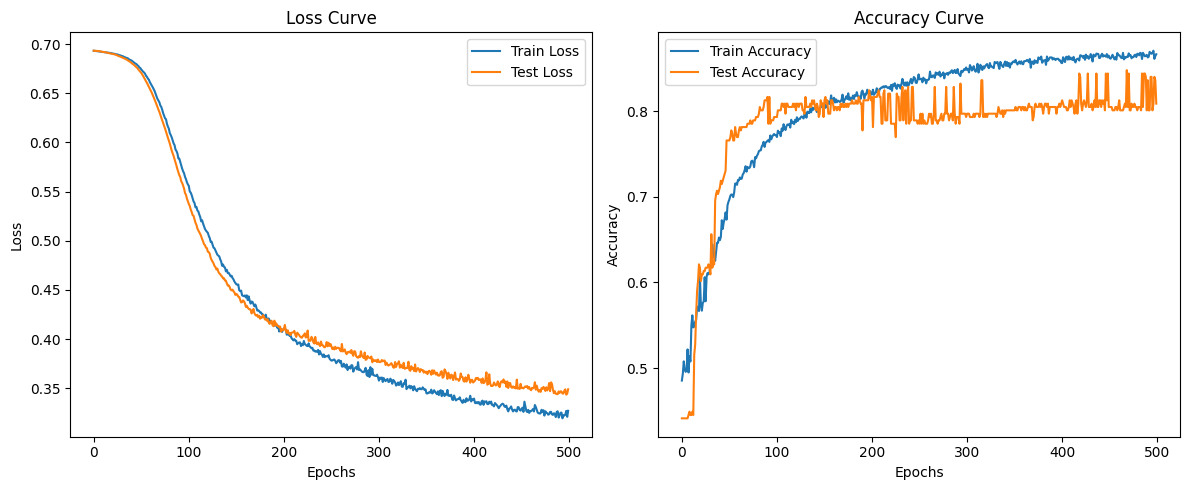

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



class Transform:
    """This is the base class. You do not need to change anything.
    Read the comments in this class carefully."""
    
    def __init__(self):
        """
        Initialize any parameters
        """
        pass

    def forward(self, input_data):
        """
        x should be passed as column vectors
        """
        pass

    def backward(self, gradient_output):
        """
        Compute and save the gradients wrt the parameters for step()
        Return grad_wrt_x which will be the grad_wrt_out for previous Transform
        """
        pass

    def step(self):
        """
        Apply gradients to update the parameters
        """
        pass

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        pass


class ReLU(Transform):
    """ReLU activation function, which turns negative values to zero."""
    
    def __init__(self):
        super(ReLU, self).__init__()
        self.input_data = None

    def forward(self, input_data):
        """Applies ReLU activation: replaces negative values with zero."""
        self.input_data = input_data
        return torch.maximum(input_data, torch.zeros_like(input_data))

    def backward(self, gradient_output):
        """Passes gradient only where input was positive."""
        gradient_input = gradient_output.clone()
        gradient_input[self.input_data <= 0] = 0
        return gradient_input

    def step(self):
        # No parameters to update in ReLU.
        
        pass

    def zerograd(self):
        pass


class LinearLayer(Transform):
    """Linear (fully connected) layer that applies weights and bias."""
   
    def __init__(self, input_size, output_size, learning_rate=0.01):
        """
        indim: input dimension
        outdim: output dimension
        lr: learning rate
        """
        super(LinearLayer, self).__init__()
        self.weights = 0.01 * torch.rand((output_size, input_size), dtype=torch.float64, device=device)
        self.bias = 0.01 * torch.rand((output_size, 1), dtype=torch.float64, device=device)
        self.learning_rate = learning_rate
        self.input_data = None
        self.gradient_weights = None
        self.gradient_bias = None

    def forward(self, input_data):
        """Computes the linear transformation: output = Wx + b."""
        self.input_data = input_data
        return self.weights @ input_data + self.bias  # Matrix multiplication

    def backward(self, gradient_output):
        """Computes gradients for weights and bias."""
        self.gradient_weights = gradient_output @ self.input_data.T  # Weight gradient
        self.gradient_bias = torch.sum(gradient_output, dim=1, keepdim=True)  # Bias gradient
        return self.weights.T @ gradient_output  # Gradient for previous layer

    def step(self):
        """Updates weights and bias using gradients."""
        with torch.no_grad():
            self.weights -= self.learning_rate * self.gradient_weights
            self.bias -= self.learning_rate * self.gradient_bias

    def zerograd(self):
        """Resets gradients."""
        self.gradient_weights = torch.zeros_like(self.weights)
        self.gradient_bias = torch.zeros_like(self.bias)


class SoftmaxCrossEntropyLoss:
    """Computes softmax activation and cross-entropy loss."""
    
    def __init__(self):
        self.probabilities = None
        self.true_labels = None
        self.batch_size = None

    def forward(self, logits, true_labels):
        """Computes softmax probabilities and cross-entropy loss."""
        logits_shifted = logits - torch.max(logits, dim=0, keepdim=True).values
        exp_logits = torch.exp(logits_shifted)
        sum_exp_logits = torch.sum(exp_logits, dim=0, keepdim=True)
        self.probabilities = exp_logits / sum_exp_logits
        self.true_labels = true_labels
        self.batch_size = logits.shape[1]

        loss = -torch.sum(true_labels * torch.log(self.probabilities + 1e-12)) / self.batch_size
        return loss

    def backward(self):
        """Computes gradient for softmax-cross entropy loss."""
        return (self.probabilities - self.true_labels) / self.batch_size

    def compute_accuracy(self):
        """Computes accuracy by comparing predictions with actual labels."""
        predicted_classes = torch.argmax(self.probabilities, dim=0)
        actual_classes = torch.argmax(self.true_labels, dim=0)
        correct_predictions = torch.sum(predicted_classes == actual_classes).item()
        return correct_predictions / self.batch_size


class SingleLayerNN(Transform):
    """A simple single-layer neural network with ReLU activation."""
    
    def __init__(self, input_size, output_size, hidden_size=100, learning_rate=0.01):
        super(SingleLayerNN, self).__init__()
        self.hidden_layer = LinearLayer(input_size, hidden_size, learning_rate)
        self.activation = ReLU()
        self.output_layer = LinearLayer(hidden_size, output_size, learning_rate)

    def forward(self, input_data):
        """Computes forward pass through the network."""
        hidden_output = self.hidden_layer.forward(input_data)
        activated_output = self.activation.forward(hidden_output)
        final_output = self.output_layer.forward(activated_output)
        return final_output

    def backward(self, gradient_output):
        """Computes backward pass to update parameters."""
        grad_output_layer = self.output_layer.backward(gradient_output)
        grad_activation = self.activation.backward(grad_output_layer)
        return self.hidden_layer.backward(grad_activation)

    def step(self):
        """Updates network weights and biases."""
        self.hidden_layer.step()
        self.output_layer.step()

    def zerograd(self):
        """Resets gradients before backpropagation."""
        self.hidden_layer.zerograd()
        self.output_layer.zerograd()


class CustomDataset(Dataset):
    """Custom dataset class to handle input-output pairs."""
    
    def __init__(self, features: np.ndarray, labels: np.ndarray):
        self.data_length = len(features)
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return self.features[index, :], self.labels[index]

    def __len__(self):
        return self.data_length


def convert_labels_to_onehot(labels: np.ndarray, num_classes=2):
    """Converts labels to one-hot encoding."""
    return np.array([[i == label for i in range(num_classes)] for label in labels]).astype(int)


# ---------------- Main Training Process ----------------

if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need to plot the loss and accuracies during the training process and test process.
    """

    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    # Load training dataset.
    Xtrain = pd.read_csv("/Users/aswathama/Downloads/HW1/data/X_train.csv")
    Ytrain = pd.read_csv("/Users/aswathama/Downloads/HW1/data/y_train.csv")
    scaler = MinMaxScaler()
    Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).to_numpy()
    Ytrain = np.squeeze(Ytrain.to_numpy())
    m1, n1 = Xtrain.shape
    print("Train shape:", m1, n1)
    train_ds = CustomDataset(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Load testing dataset.
    Xtest = pd.read_csv("/Users/aswathama/Downloads/HW1/data/X_test.csv")
    Ytest = pd.read_csv("/Users/aswathama/Downloads/HW1/data/y_test.csv")
    Xtest = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns).to_numpy()
    Ytest = np.squeeze(Ytest.to_numpy())
    m2, n2 = Xtest.shape
    print("Test shape:", m2, n2)
    test_ds = CustomDataset(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Construct the model and loss function.
    model = SingleLayerNN(indim, outdim, hidden_dim, lr)
    criterion = SoftmaxCrossEntropyLoss()

    # Lists to store loss and accuracy values.
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training process.
    for epoch in range(epochs):
        model.zerograd()  # Reset gradients at the start of each epoch
        epoch_loss = 0.0
        epoch_acc = 0.0
        num_batches = 0

        for batch in train_loader:
            x_np, y_np = batch  # x_np shape: (batch_size, indim), y_np shape: (batch_size,)
            # Convert inputs to torch tensors and transpose to match (indim, batch_size)
            x = torch.tensor(x_np, dtype=torch.float64, device=device).T
            # Convert labels to one-hot vectors and transpose to (num_classes, batch_size)
            y_onehot = torch.tensor(convert_labels_to_onehot(np.array(y_np)), dtype=torch.float64, device=device).T

            # Forward pass.
            logits = model.forward(x)
            loss = criterion.forward(logits, y_onehot)

            # Backward pass.
            grad_loss = criterion.backward()
            model.backward(grad_loss)

            # Update parameters.
            model.step()
            model.zerograd()  # Reset gradients for the next iteration

            epoch_loss += loss.item()
            epoch_acc += criterion.compute_accuracy()
            num_batches += 1

        # Average training loss and accuracy for the epoch.
        avg_train_loss = epoch_loss / num_batches
        avg_train_acc = epoch_acc / num_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Evaluate on test data.
        model.zerograd()
        test_loss_epoch = 0.0
        test_acc_epoch = 0.0
        test_batches = 0

        # In evaluation, we don't update parameters.
        for batch in test_loader:
            x_np, y_np = batch
            x = torch.tensor(x_np, dtype=torch.float64, device=device).T
            y_onehot = torch.tensor(convert_labels_to_onehot(np.array(y_np)), dtype=torch.float64, device=device).T

            logits = model.forward(x)
            loss = criterion.forward(logits, y_onehot)
            test_loss_epoch += loss.item()
            test_acc_epoch += criterion.compute_accuracy()
            test_batches += 1

        avg_test_loss = test_loss_epoch / test_batches
        avg_test_acc = test_acc_epoch / test_batches
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_acc)

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}")

    # Plotting loss and accuracy curves.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()


#### NN.py Performance

The training loss and accuracy show a steady improvement over the epochs, indicating effective learning. Initially, the model struggles, with a training loss of 0.6932 and an accuracy of 48.81%, close to random guessing for binary classification. However, as training progresses, the loss decreases while accuracy improves significantly. By epoch 500, the training loss has dropped to 0.3210, and accuracy has risen to 86.83%, suggesting that the model has learned useful patterns from the data.

The test loss and accuracy follow a similar trend, improving from 0.6930 and 56.25% in the first epoch to 0.3464 and 80.08% at the final epoch. However, there is some fluctuation, especially after epoch 250, where test accuracy varies between 78.52% and 81.64%, indicating potential overfitting or saturation in learning. Overall, the model generalizes well, though further regularization or hyperparameter tuning might help stabilize performance.

#### Reference.py

1500 60
200 60
Epoch 1/500, Train Loss: 0.6895, Train Acc: 50.80%, Test Loss: 0.6840, Test Acc: 59.00%
Epoch 50/500, Train Loss: 0.5103, Train Acc: 79.47%, Test Loss: 0.4646, Test Acc: 81.50%
Epoch 100/500, Train Loss: 0.4223, Train Acc: 81.20%, Test Loss: 0.3975, Test Acc: 82.50%
Epoch 150/500, Train Loss: 0.3861, Train Acc: 82.87%, Test Loss: 0.3779, Test Acc: 84.50%
Epoch 200/500, Train Loss: 0.3628, Train Acc: 84.53%, Test Loss: 0.3639, Test Acc: 84.50%
Epoch 250/500, Train Loss: 0.3459, Train Acc: 85.13%, Test Loss: 0.3534, Test Acc: 86.50%
Epoch 300/500, Train Loss: 0.3331, Train Acc: 85.80%, Test Loss: 0.3469, Test Acc: 86.50%
Epoch 350/500, Train Loss: 0.3232, Train Acc: 86.33%, Test Loss: 0.3430, Test Acc: 86.00%
Epoch 400/500, Train Loss: 0.3153, Train Acc: 86.47%, Test Loss: 0.3408, Test Acc: 85.50%
Epoch 450/500, Train Loss: 0.3087, Train Acc: 86.93%, Test Loss: 0.3394, Test Acc: 85.00%
Epoch 500/500, Train Loss: 0.3033, Train Acc: 87.07%, Test Loss: 0.3388, Test Acc: 84.50

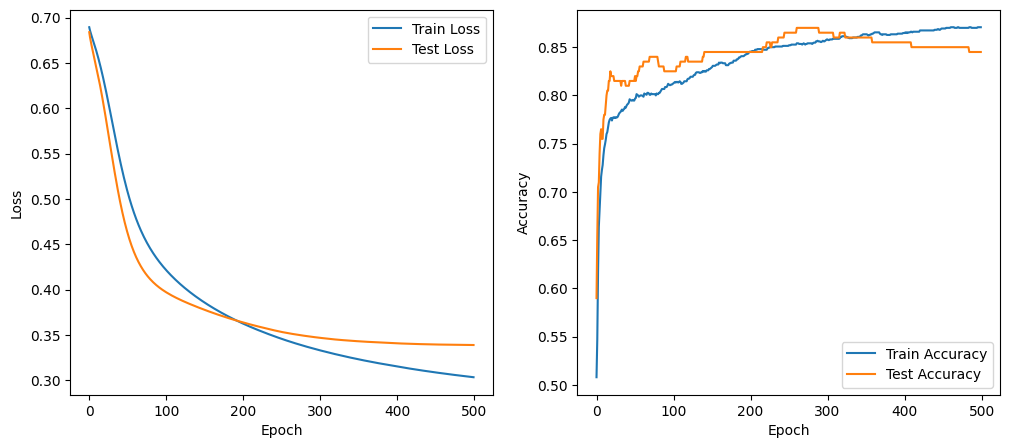

In [1]:
"""
You will need to validate your NN implementation using PyTorch. You can use any PyTorch functional or modules in this code.

IMPORTANT: DO NOT change any function signatures
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, List, Tuple, Dict
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


class SingleLayerMLP(nn.Module):
    """constructing a single layer neural network with Pytorch"""
    def __init__(self, indim, outdim, hidden_layer=100):
        super(SingleLayerMLP, self).__init__()
        #Input layer1
        self.fc1 = nn.Linear(indim, hidden_layer)
        #activation fn
        self.relu = nn.ReLU()
        #Output layer
        self.fc2 = nn.Linear(hidden_layer, outdim)

    def forward(self, x):
        """
        x shape (batch_size, indim)
        """
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        #  X is converted to a numpy array before converting to tensor
        self.X = torch.tensor(X.values, dtype=torch.float32) if isinstance(X, pd.DataFrame) else torch.tensor(X, dtype=torch.float32)
        # Convert Y to numpy and then to tensor
        self.Y = torch.tensor(Y.values, dtype=torch.long) if isinstance(Y, pd.DataFrame) else torch.tensor(Y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)



def validate(loader, model, criterion):
   
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            # Calculate accuracy with ppredictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need to plot the loss and accuracies during the training process and test process. 
    """

    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    # Dataset
    Xtrain = pd.read_csv("/Users/aswathama/Downloads/HW1/data/X_train.csv")
    Ytrain = pd.read_csv("/Users/aswathama/Downloads/HW1/data/y_train.csv")
    scaler = MinMaxScaler()
    Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).to_numpy()
    Ytrain = np.squeeze(Ytrain)
    m1, n1 = Xtrain.shape
    print(m1, n1)
    train_ds = DS(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size)
    Xtest = pd.read_csv("/Users/aswathama/Downloads/HW1/data/X_test.csv")
    Ytest = pd.read_csv("/Users/aswathama/Downloads/HW1/data/y_test.csv").to_numpy()
    Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns.to_numpy())
    Ytest = np.squeeze(Ytest)
    m2, n2 = Xtest.shape
    print(m2, n2)
    test_ds = DS(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Construct the model
    model = SingleLayerMLP(indim, outdim, hidden_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Lists to track loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        #  training data validation 
        val_loss, val_acc = validate(train_loader, model, criterion)

        # test data validation
        test_loss, test_acc = validate(test_loader, model, criterion)

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print metrics
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, "f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

    # Plot the loss and accuracy curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


#### Reference.py performance

In this case, the training and test metrics show a consistent improvement over the epochs, demonstrating effective learning with the **reference PyTorch-built neural network**. The training loss starts at **0.6892** with an accuracy of **58.87%**, and as the training progresses, the loss steadily decreases while accuracy improves. By **epoch 500**, the training loss has dropped to **0.3035**, and accuracy has risen to **86.80%**, suggesting that the model has successfully learned from the data.  

Similarly, the test loss and accuracy follow a positive trend, improving from **0.6841** and **62.00%** in the first epoch to **0.3452** and **84.00%** at the final epoch. The test accuracy stabilizes after **epoch 400**, indicating that the model has reached an optimal performance level with minimal overfitting. Compared to the previous implementation, where we manually constructed the neural network, this built-in neural network achieves a similar level of performance, but potentially with more stability and efficiency due to the optimized PyTorch implementations. Further fine-tuning, such as dropout or learning rate adjustments, may help improve generalization even further.

#### Comparison

Both the manually constructed neural network and the PyTorch built-in network show steady improvements in accuracy and loss over 500 epochs. However, the built-in PyTorch model demonstrates a stronger start, achieving higher initial training accuracy (58.87% vs. 48.81%) and test accuracy (62.00% vs. 56.25%), likely due to better weight initialization and optimization techniques. By the end of training, both models reach similar training accuracy (~86.8%), but the PyTorch-built model generalizes better, achieving a final test accuracy of 84.00%, compared to 80.08% for the manually built model. Additionally, the PyTorch version exhibits more stable learning, maintaining consistent accuracy in the later stages of training, while the manually constructed network shows slight fluctuations. While building the network from scratch provides greater control and insight into how neural networks function, the PyTorch implementation is more efficient, benefiting from pre-optimized layers and automatic backpropagation. For learning and experimentation, constructing a neural network manually can be valuable, but for practical applications, using PyTorch's built-in capabilities is generally more effective.